### 0. Simulate XRD data (target_xrd) as Rita's input 

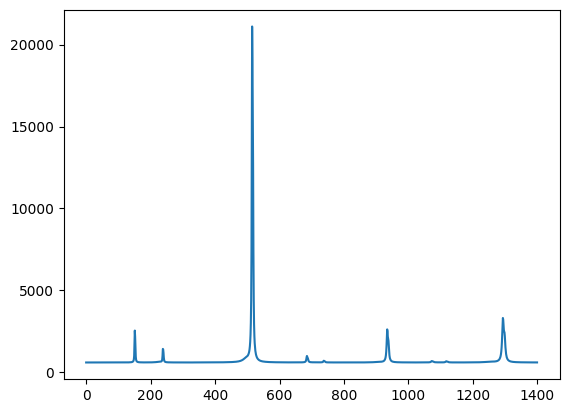

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from b2.gsas import GSASModel
target_model = GSASModel("Al-Ni-dual-phase.gpx")

# targ_xrd is the xrd from Rita
targ_xrd = target_model.forward(mustrain=10000, grainsize = 0.01)
plt.plot(targ_xrd)

Define Functions
* get_logMSE(), improved function incorporating fitness(), designed for GPR
* fitness(), basic function designed for Newton's method
* interpretXRD(), used for method

In [2]:
### use mean square error, find the difference between two graphs
import numpy as np
from sklearn.metrics import mean_squared_error

# define a function to compute the difference between the target and the model
def fitness(target, test):
    '''returns the fitness of a model(ndarray) compared to a target(ndarray)'''
    
    #check if the length of the two arrays are the same
    if len(target) != len(test):
        raise ValueError("The two arrays must have the same length")
    
    # return the mean squared error between the two arrays
    mse = mean_squared_error(target, test)
    mse_log = np.log10(mse)
    # inv_mse = np.log10(100/mse)
    return mse_log

In [136]:
### Define MSE evaluation fucntion catered for approach 1
def get_logMSE(log_gs, log_mu, model = target_model, target_xrd = targ_xrd, log10 = True):
    '''Returns the log(MSE) of the model's XRD compared to the target XRD
    log_mu: log of the mu value, value is -3 to 6 by default
    log_gs: log of the grainsize value, from 1 to 9
    model: the model used to generate the XRD
    target_xrd: the target XRD given by Rita

    returns: the log(MSE) of the model's XRD compared to the target'''
    # when array of numbers is passed
    if isinstance(log_mu, np.ndarray) and isinstance(log_gs, np.ndarray):
        # for each item in each array, generate a model and compare to the target
        mse = []
        for gs, mu in zip(log_gs, log_mu):
            test_xrd = model.forward(grainsize = 10**gs, mustrain=10**mu)
            mse.append(mean_squared_error(target_xrd, test_xrd))

    else: # when individual number is passed
        test_xrd = model.forward(mustrain=10**log_mu, grainsize = 10**log_gs)
        mse = mean_squared_error(target_xrd, test_xrd)

    if log10:
        return np.log10(mse)
    else:
        return mse

In [4]:
# Define a function to plot the gradient of an array
def plot_gradient(array):
    '''Plots the gradient of an array, used for approach 1'''
    slopes = np.gradient(array)
    # Calculate the magnitude of the slope at each point
    slope_mag = np.sqrt(sum(slope ** 2 for slope in slopes))
    return slope_mag

#### define function to acquire new points of interest.

* problem1: std_scatter = 0.1 can be problematic. If one of the para is within a small range(e.g. 0~1) then things are not good

In [104]:
def acq_new(X, y, y_std, n_observ = 100, n_std = 2, coverage = 0.2, privilege = 10, plot = False):
    '''
    input:
    X: loction of predicted points
    y: corresponding predicted y values
    y_std: corresponding predicted y_std values
    
    parameters: for tuning, incl:
    1. n_observ: the number of points to be observed next,
    2. n_std: (0 ~ 3) balances exploitation vs. exploration. Default is the LCB criteria: mean - 2*std. Zero value -> exploitation, very large value -> exploration
    3. coverage: (n_observ/y.length ~ 1) the fraction of the points that will be considered and sampled randomly. Default 0.2 is equivalent to sampling n_observ from the top 20% prediction points 
    4. privilege: (0 ~ 1000) the higher the privilege, the more likely the top-ranked points will be sampled. Default 10 is give high ranked reasonable privilege to be sampled. 0 means perfect random sampling

    output:
    X_next: the proposed new locations to observe'''
    # get the number of input variables, for future use when there are more than 2 input variables
    dim = X.shape[1]
    length = X.shape[0]
    ### 0. initialize the df to store the input
    # make a input_df to store X. This way avoid incessent indexing across input variables
    input_df = pd.DataFrame(X)
    input_df['y_pred'], input_df['y_std'] = y, y_std
    # make a new column to store the lower confidence bound of the confidence interval
    input_df['LCB'] = input_df['y_pred'] - n_std * input_df['y_std']

    ### 1.1 select top performers (by LCB)
    # sort the df by LCB, and return the the ones with lowest LCB
    input_df = input_df.sort_values('LCB', ascending=True)

    # mini custom function which selects the top % of prediction points, and sample them with a priviledge
    n_considered = int(np.ceil(coverage * length)) # consider the top coverage% of the points
    n_lucky = int(n_observ - 1) # top 1 points is destined, so 99 points will be select based on their luck
    # weights = np.exp(np.linspace(1, 0, n_considered)) # can use linear as an alternative
    weights = np.power(np.linspace(1, 0, n_considered-1), privilege) 
    weights = weights/weights.sum()  
    indices = np.random.choice(n_considered-1, size=n_lucky, replace=False, p=weights)
    # concat the destined ones (top 1) with the lucky ones
    next_df = pd.concat([input_df.iloc[:1, :], input_df.iloc[indices, :]])

    X_next = next_df.iloc[:, :dim].values

    if plot == True:
        plt.figure(figsize = (20, 20))
        # plot the original X, color by predicted y
        predict = plt.scatter(X[:, 0], X[:, 1], c = y, s = 1, label = 'original X', cmap = 'coolwarm')
        # add a colorbar, label it
        plt.colorbar(predict, label = 'predicted Error'); plt.xlabel('log(gs)'); plt.ylabel('log(mu)')

        # plot the X to observe next as yellow circles
        plt.scatter(next_df.iloc[:, 0], next_df.iloc[:, 1], facecolors='none', edgecolors='k', marker = 'o', s = 40, label = 'to observe')

    # print('Total points: ', length, 
    #       'points considered: ', n_considered, 
    #       'points selected: ', n_observ)
    
    ### 3. return the X_next
    return X_next

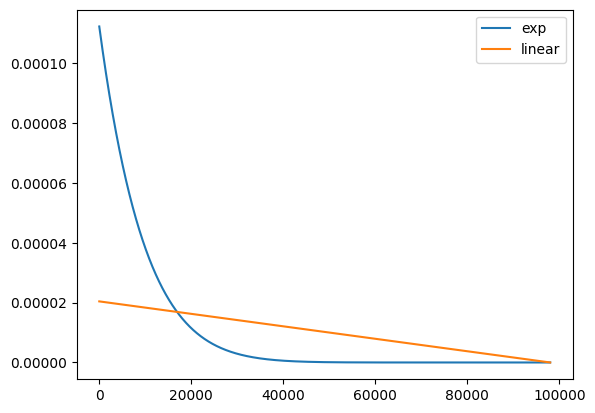

In [111]:
### toy code to demonstrate weight distribution
weights1 = np.power(np.linspace(1, 0, int(490000*0.2)), 10)
weights1 = weights1/weights1.sum()

weights2 = np.linspace(1, 0, int(490000*0.2))
weights2 = weights2/weights2.sum()
# plot two weights on the same graph
plt.plot(weights1, label = 'exp')
plt.plot(weights2, label = 'linear')
plt.legend()


* define a function which takes an resulting fitness array into instruction (a new range to explore). 

* This function returns a dictionary/dataFrame containing the new range for each parameter e.g. mustrain, GS and later, vol.fra

### <span style='color:Blue'> Approach 1. use Bayesian Optimization, minimize the number of datapoints to be measured

blackbox function is **fitness(target_xrd, model.forward(mu, gs, ...)**

Acquisition is determined by module

Benefit: minimize trial attempted

Problem: evaluating one datapoint is not too expensive. Also, have vast parameter space to explore

reference link: https://towardsdatascience.com/bayesian-optimization-with-python-85c66df711ec

In [6]:
# from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split

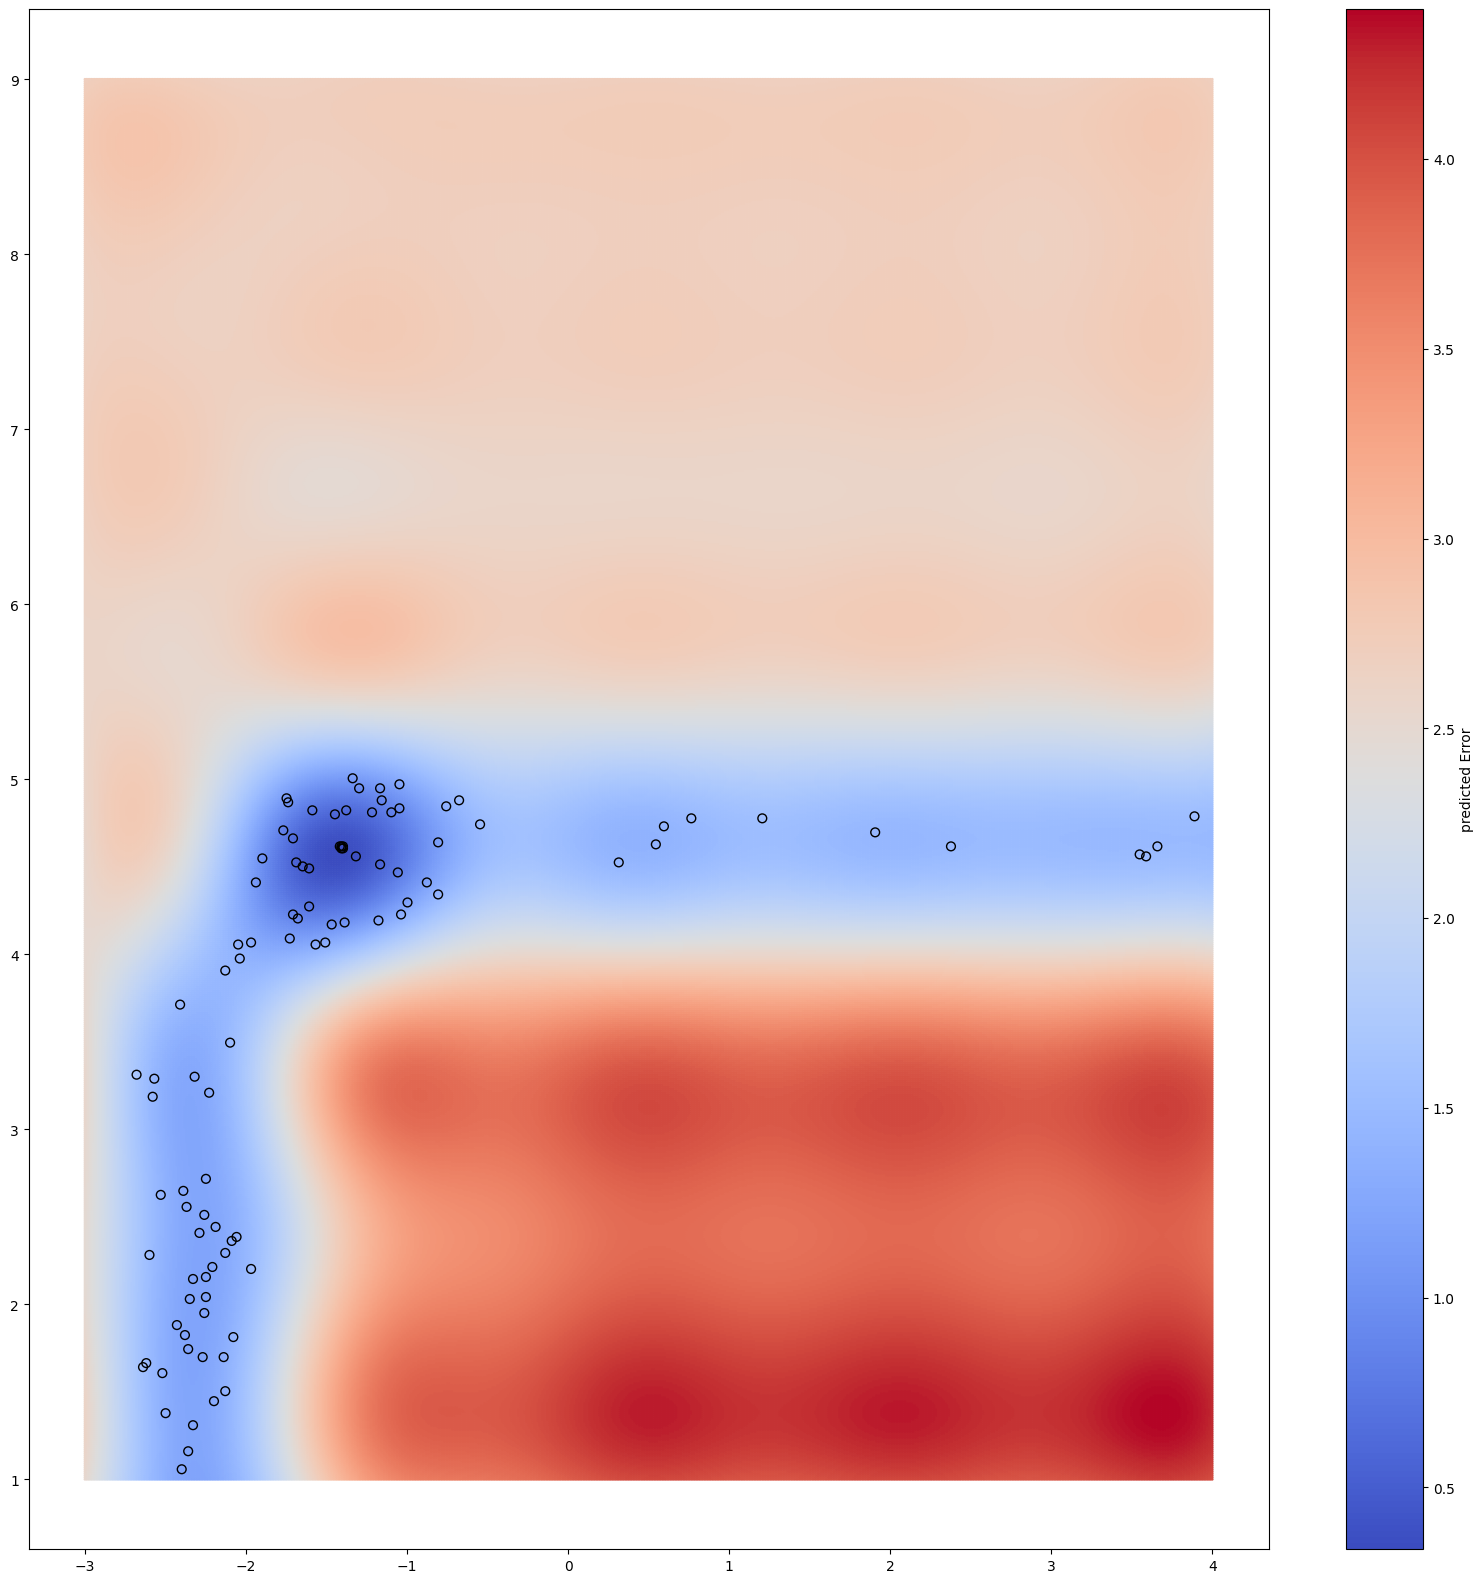

In [132]:
### stand-alone testing

first_grid = 'aligned' 

### INITIALIZE pre-loop variables
### We can start here and feed GPR the exponents of 10 instead of actual value
log_gs_min, log_gs_max = -3, 4 
log_mu_min, log_mu_max = 1, 9

if first_grid == 'random':
    # Random initial observation
    gs_train_grid = np.random.uniform(log_gs_min, log_gs_max, 100)
    mu_train_grid = np.random.uniform(log_mu_min, log_mu_max, 100)
    X_train_new = np.vstack((gs_train_grid, mu_train_grid)).T
elif first_grid == 'aligned':
    # Grid initial observation
    gs_train_grid = np.linspace(log_gs_min, log_gs_max, 10)
    mu_train_grid = np.linspace(log_mu_min, log_mu_max, 10)
    # use meshgrid to generate all possible combinations between range_a and range_b
    aa, bb = np.meshgrid(gs_train_grid, mu_train_grid)
    # stack the resulting 2D arrays horizontally to create a 2-column array
    X_train_new = np.column_stack((aa.ravel(), bb.ravel()))




# y_train_new = []
# for i in range(len(X_train_new)):
#     test_xrd = target_model.forward(grainsize = 10**X_train_new[i, 0], mustrain=10**X_train_new[i, 1])
#     mse = mean_squared_error(targ_xrd, test_xrd)
#     mse = np.log10(mse)
#     y_train_new.append(mse)

# y_train_new = np.array(y_train_new)

y_train_new = get_logMSE(X_train_new[:,0], X_train_new[:,1], model = target_model, target_xrd = targ_xrd)




kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-5, 1))
### define a linear kernel, not considering for now
# kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-1, 5)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
GPR = GaussianProcessRegressor(kernel = kernel,
                               n_restarts_optimizer=9, # this is still arbitrary...
                               random_state=0, 
                               normalize_y=False
                               )

GPR.fit(X_train_new, y_train_new)

# generate prediction grid for GPR to predict
gs_grid = np.linspace(log_gs_min, log_gs_max, 700) # use the same range but higher resolution
mu_grid = np.linspace(log_mu_min, log_mu_max, 700)
grid = np.meshgrid(gs_grid, mu_grid)
X_pred_grid = np.vstack((grid[0].ravel(), grid[1].ravel())).T 

y_pred_mean, y_pred_std = GPR.predict(X_pred_grid, return_std=True)

X_train_new = acq_new(X_pred_grid, y_pred_mean, y_pred_std, n_std=1, privilege=5, plot=True)

/Users/baishipu/opt/anaconda3/envs/ThesisEnv/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/baishipu/opt/anaconda3/envs/ThesisEnv/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/baishipu/opt/anaconda3/envs/ThesisEnv/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

best observation: gs =  0.009017430951144682 mu =  1264.423490648145 MSE =  2.488936747592405
best  prediction: gs =  0.013539935488288751 mu =  2161.543343605167 MSE =  0.3155550316198448


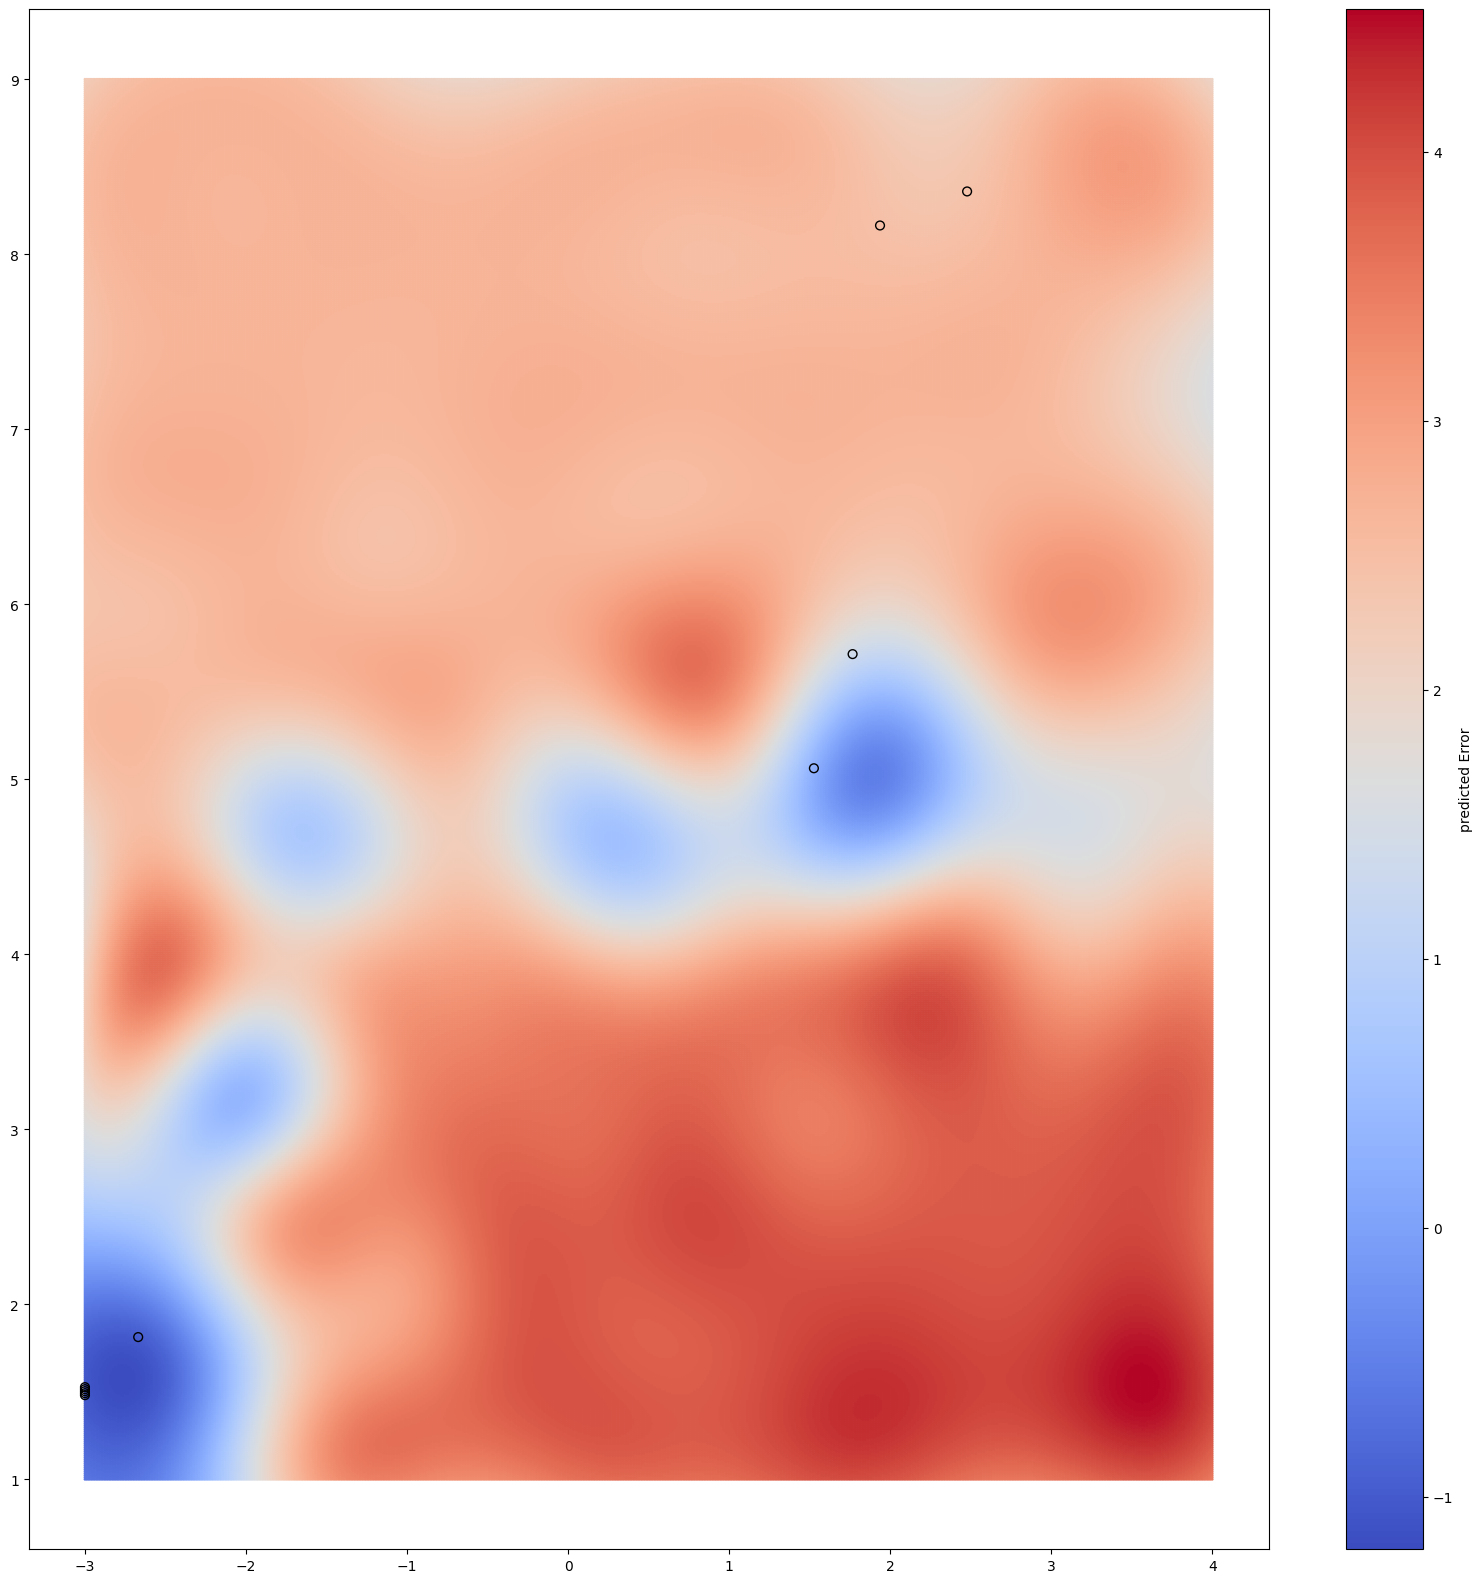

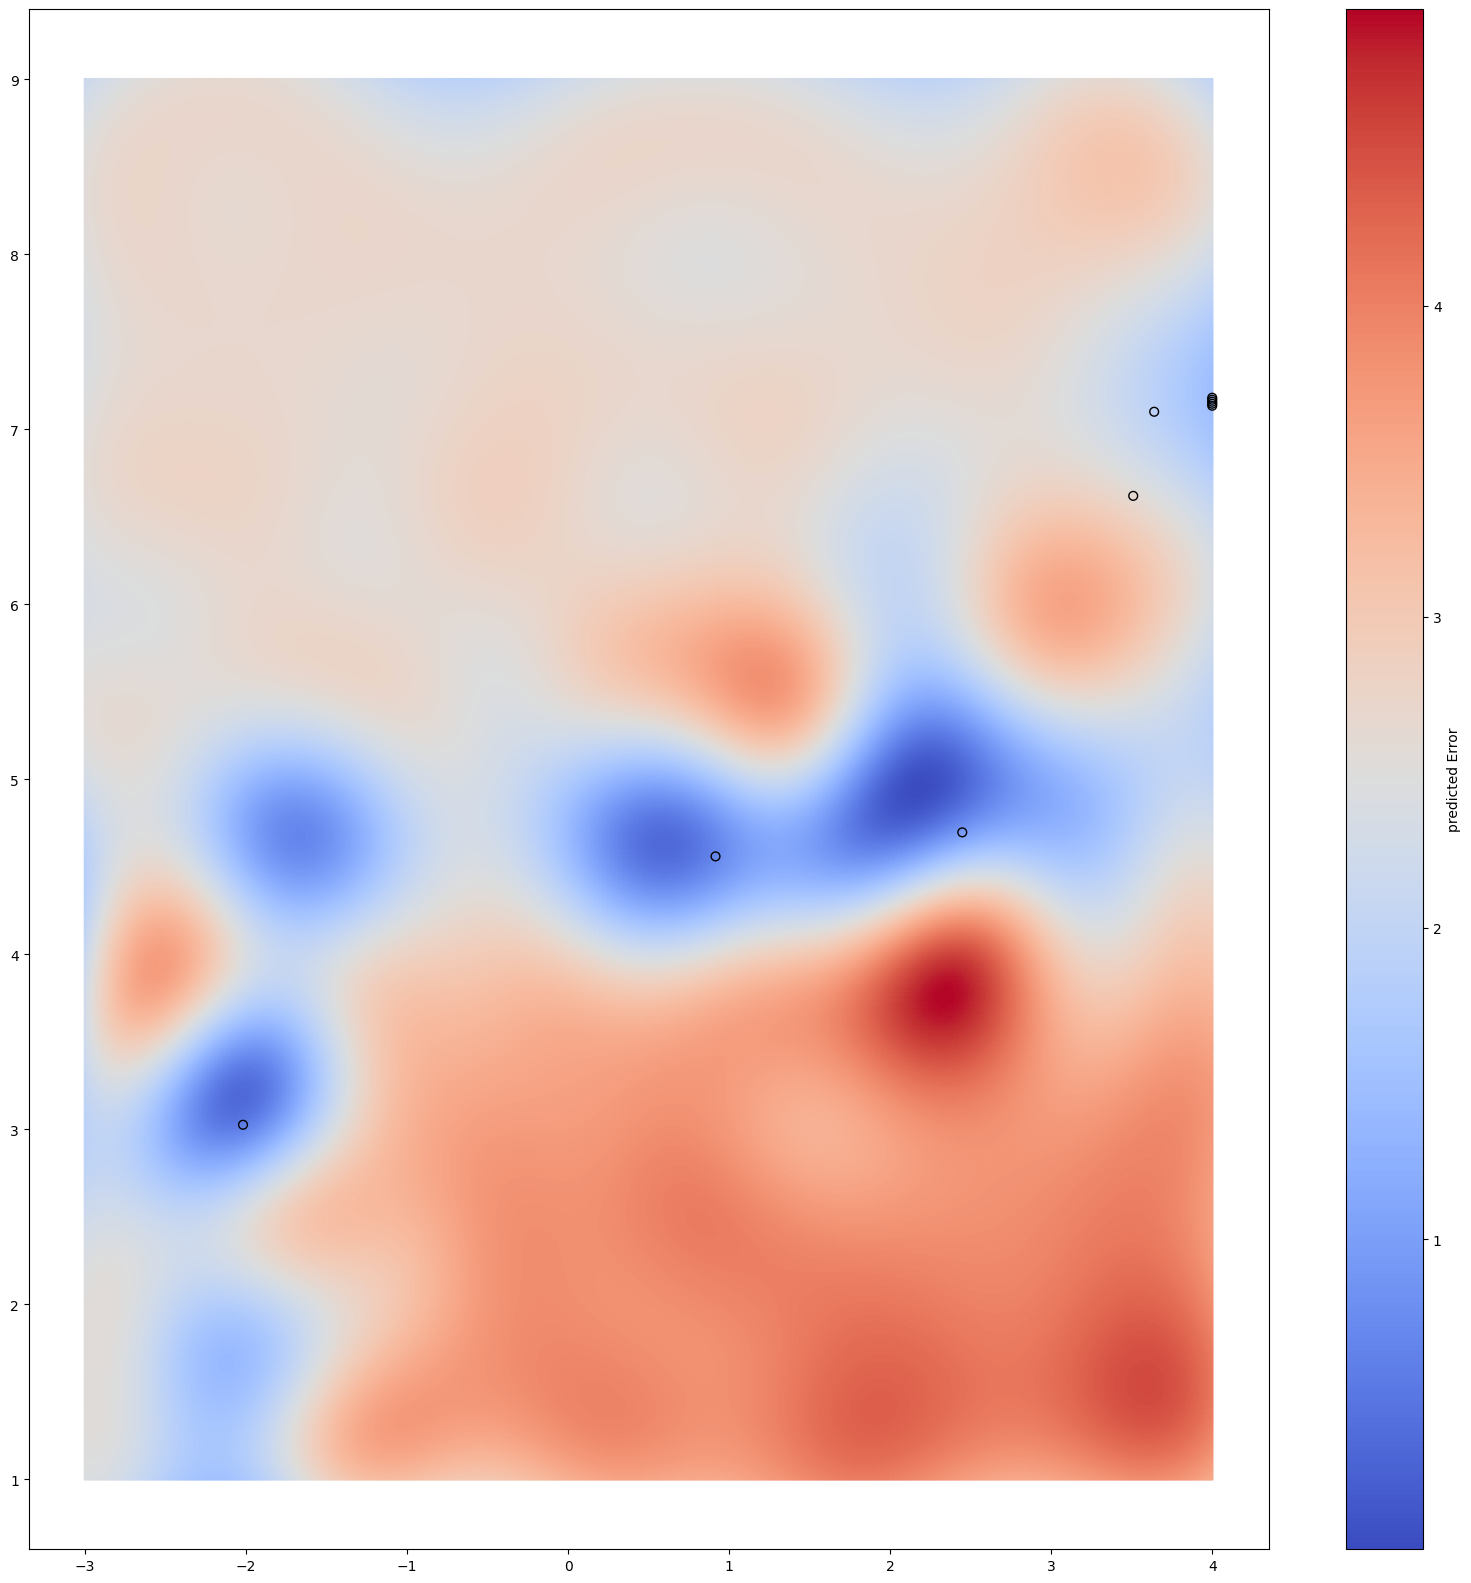

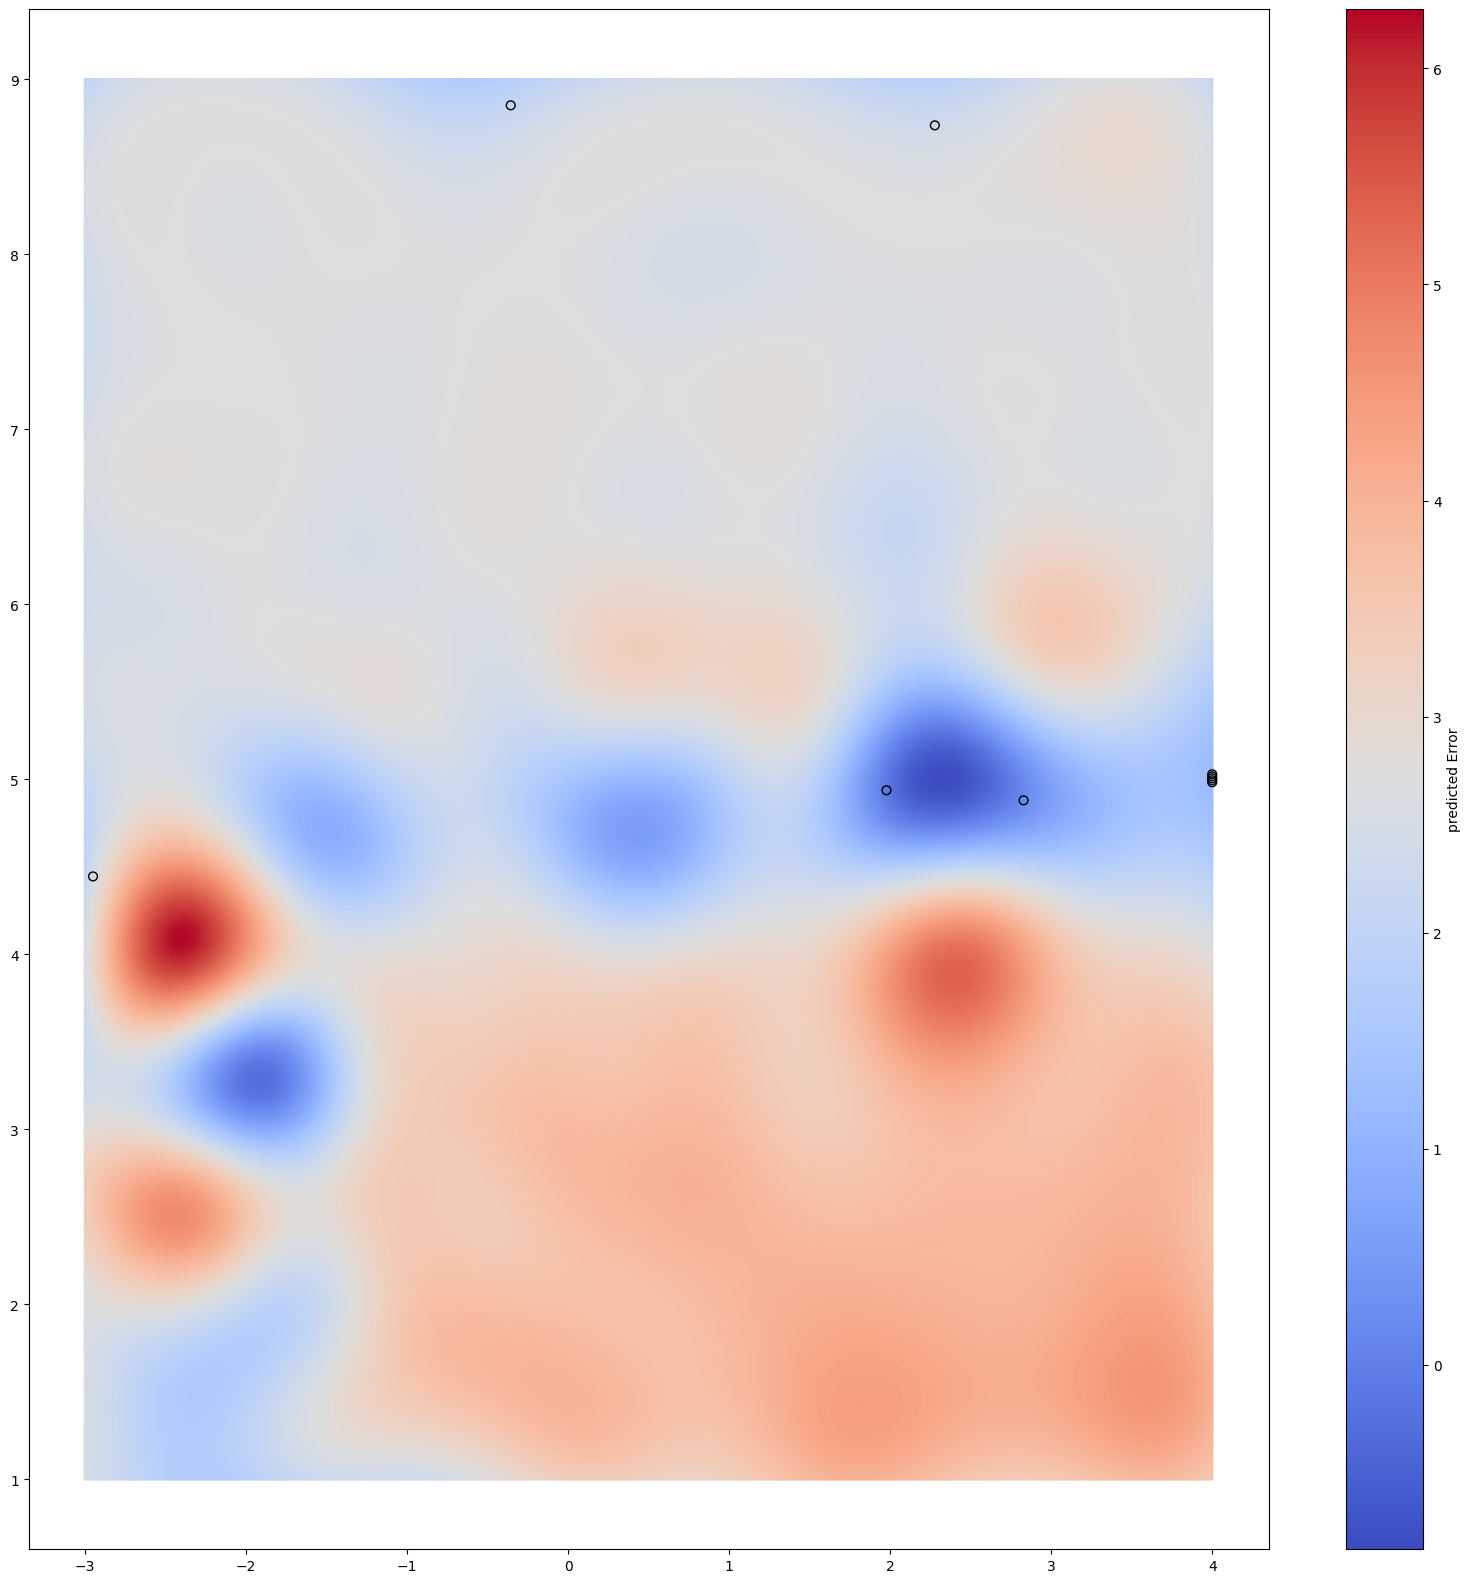

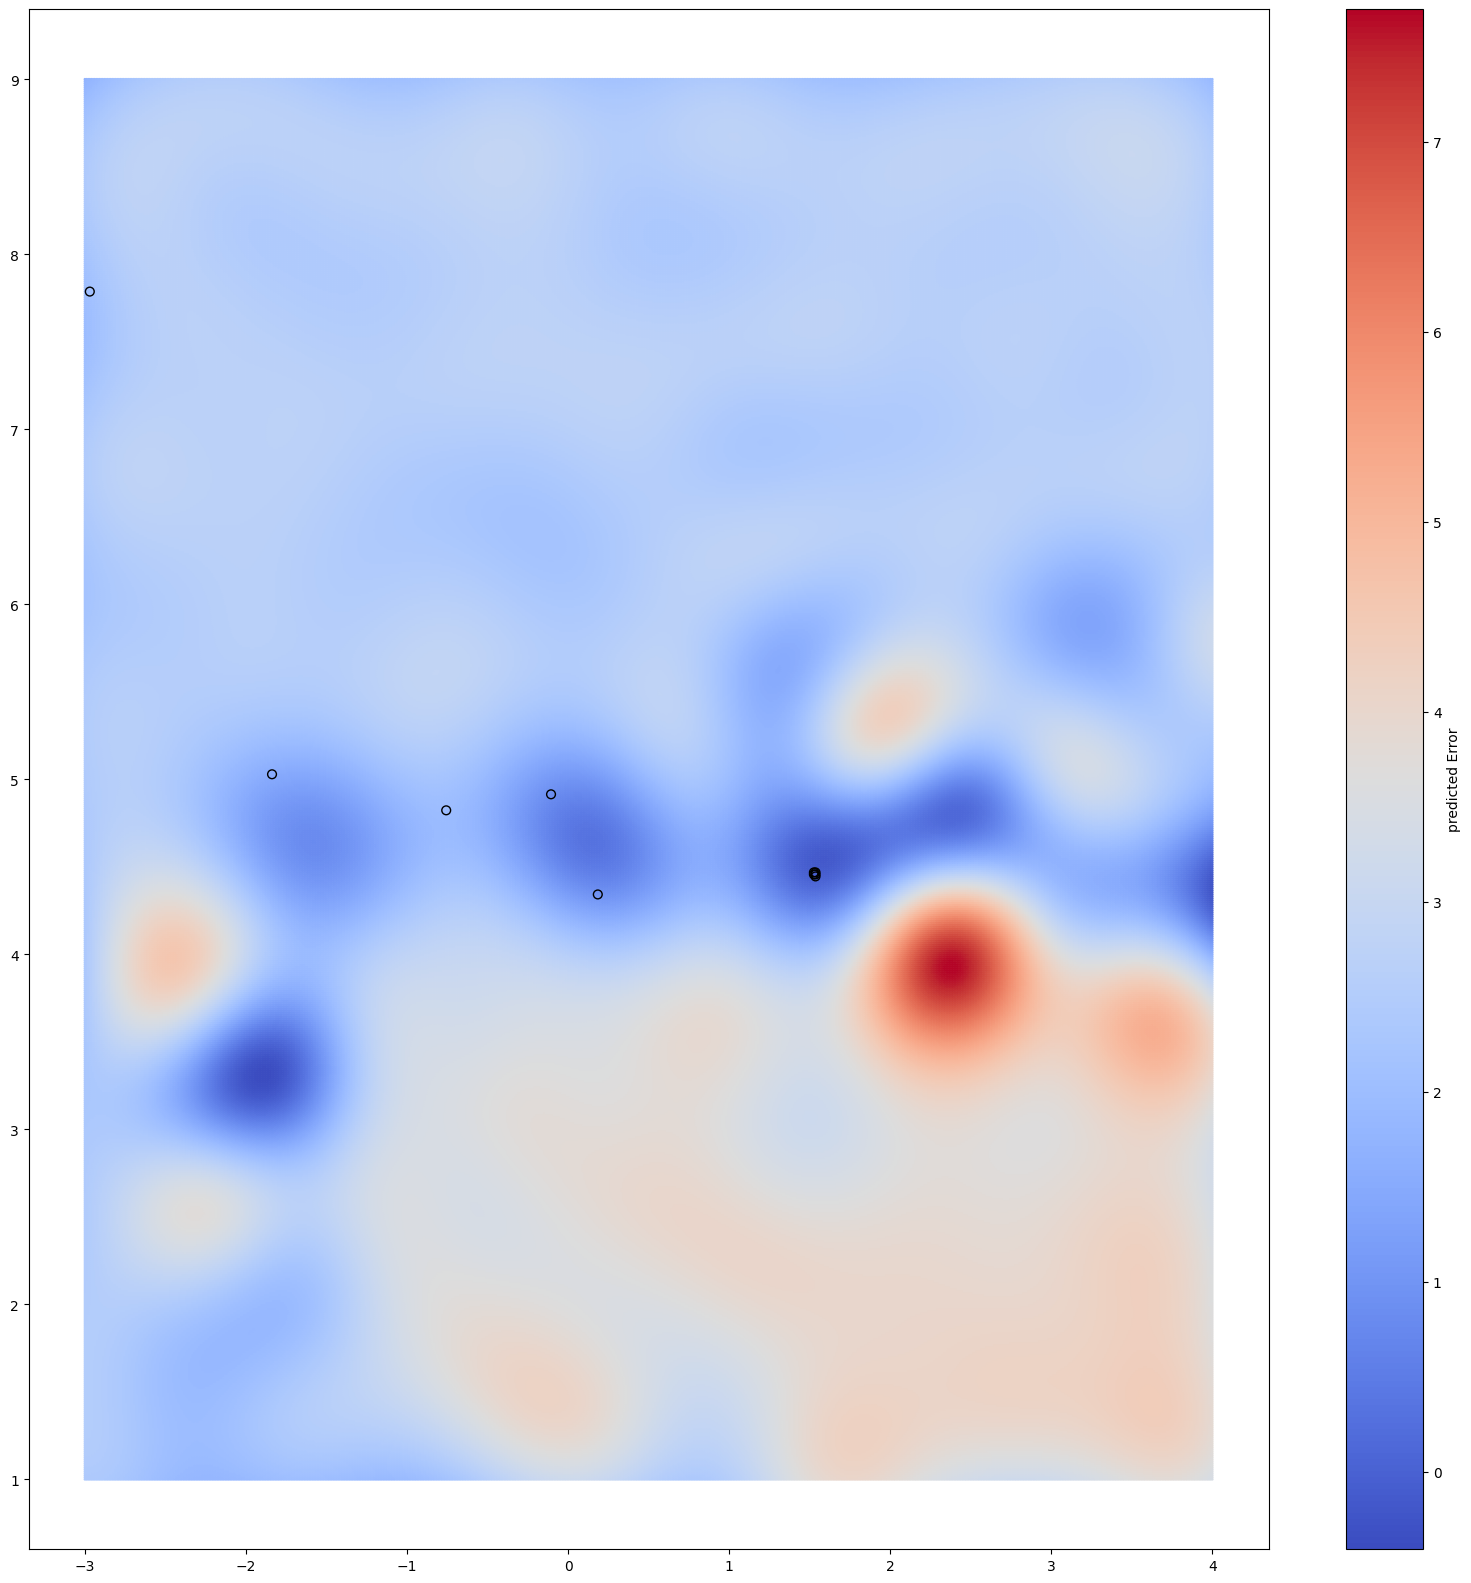

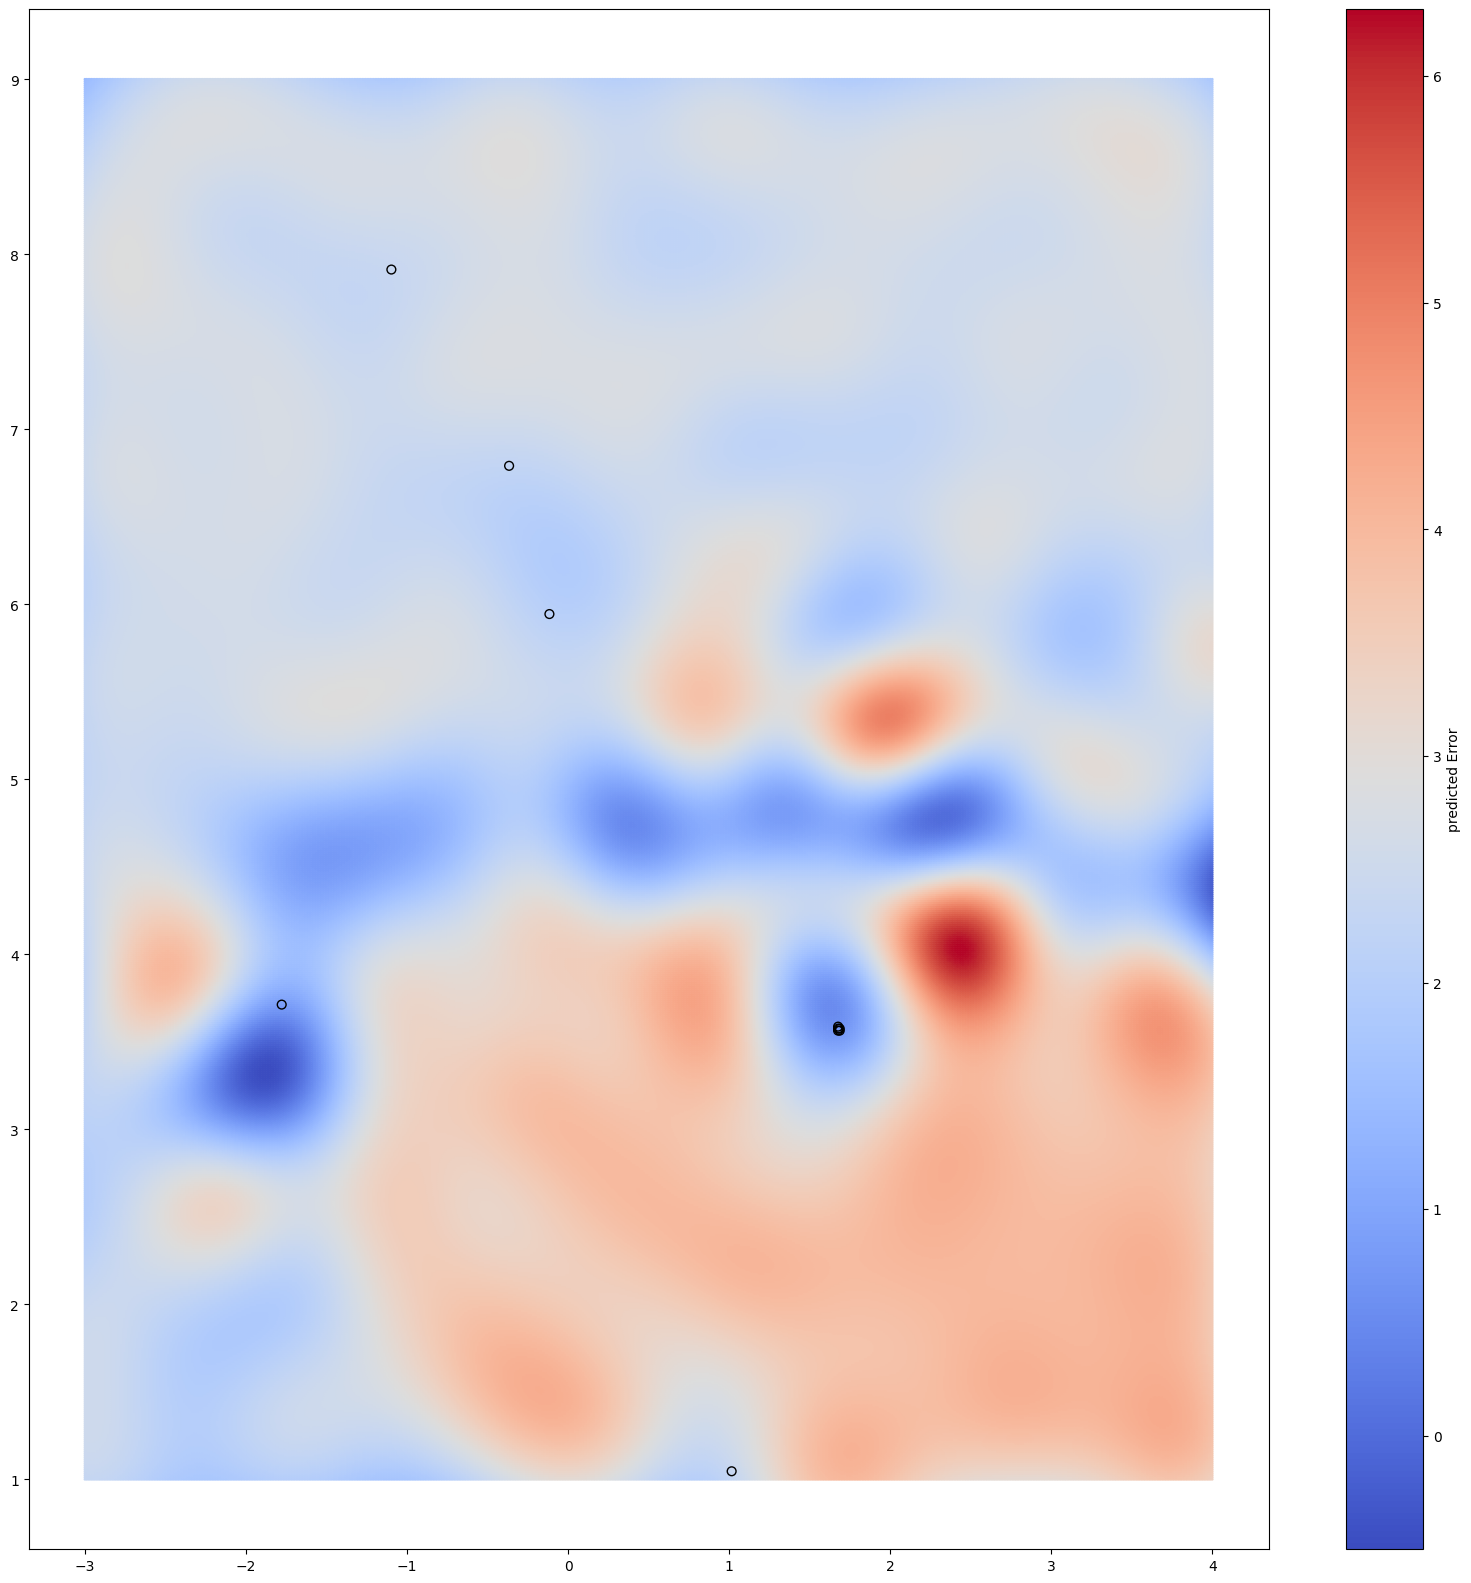

In [139]:
'''STEP 1: INITIALIZE: DEFINE TRAINING SPACE AND DENSITY, TRAIN, PREDICT 700*700 GRID'''

first_grid = 'random' 

### INITIALIZE pre-loop variables
### We can start here and feed GPR the exponents of 10 instead of actual value
log_gs_min, log_gs_max = -3, 4 
log_mu_min, log_mu_max = 1, 9

if first_grid == 'random':
    # Random initial observation
    gs_train_grid = np.random.uniform(log_gs_min, log_gs_max, 100)
    mu_train_grid = np.random.uniform(log_mu_min, log_mu_max, 100)
    X_train_new = np.vstack((gs_train_grid, mu_train_grid)).T
elif first_grid == 'aligned':
    # Grid initial observation
    gs_train_grid = np.linspace(log_gs_min, log_gs_max, 10)
    mu_train_grid = np.linspace(log_mu_min, log_mu_max, 10)
    # use meshgrid to generate all possible combinations between range_a and range_b
    aa, bb = np.meshgrid(gs_train_grid, mu_train_grid)
    # stack the resulting 2D arrays horizontally to create a 2-column array
    X_train_new = np.column_stack((aa.ravel(), bb.ravel()))

dim = X_train_new.shape[1]

# Initialize kernal & GPR
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-10, 1))
### define a linear kernel, not considering for now
# kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-1, 5)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
GPR = GaussianProcessRegressor(kernel = kernel,
                               n_restarts_optimizer=9, # this is still arbitrary...
                               random_state=0, 
                               normalize_y=False
                               )
# make an empty dataframe for training data (ground truths), with columns log_gs and log_mu, and log_MSE
train_df = pd.DataFrame(columns = ['log_gs', 'log_mu', 'log_MSE'])

# Initialize the range for prediction (always predict on the same grid)
gs_grid = np.linspace(log_gs_min, log_gs_max, 700) # use the same range but higher resolution
mu_grid = np.linspace(log_mu_min, log_mu_max, 700)
grid = np.meshgrid(gs_grid, mu_grid)
X_pred_grid = np.vstack((grid[0].ravel(), grid[1].ravel())).T 

# now we have the training data, proceed to train the model

'''STEP 2 DEFINE GPR, TRAIN MODEL. THEN DEFINE PREDICTING RANGE AND DENSITY
INSERT FOR LOOP HERE. In each loop:
1. 100x training location is fed in
2. corresponding y_train observed, 
3. training X, y appended
4. GPR trained on entire data
5. GPR spits y_mean, y_std
6. which is feed into acq_new, where new X_train is spit out
'''

# THE LOOP, breaks when truth is found
for i in range(5):
    # 1 & 2: for every row in X_train, observe, calculate the MSE and put it in y_train
    y_train_new = get_logMSE(X_train_new[:,0], X_train_new[:,1], model = target_model, target_xrd = targ_xrd)
    # make a train_new_df with the same column names as train_df
    train_new_df = pd.DataFrame()
    # fill in the values
    train_new_df['log_gs'] = X_train_new[:,0]
    train_new_df['log_mu'] = X_train_new[:,1]
    train_new_df['log_MSE'] = y_train_new

    # 3. append the new training data to the old training data
    train_df = train_df.append(train_new_df, ignore_index=True)

    # 4. train the model
    GPR.fit(train_df.iloc[:, :dim].values, train_df['log_MSE'])

    # 5. predict the mean and std of the prediction over the prediction grid
    y_pred_mean, y_pred_std = GPR.predict(X_pred_grid, return_std=True)

    # 6. find the next X_train_new by feeding y_pred_mean and y_pred_std into acq_new
    # if i == 19, set plot_bool to True to plot the last iteration
    X_train_new = acq_new(X_pred_grid, y_pred_mean, y_pred_std, n_std=2, n_observ=10, privilege=5, plot=True)


# print the best observation & prediction
observ_best = train_df.iloc[train_df['log_MSE'].idxmin(), :].values
print('best observation: gs = ' , 10**observ_best[0], 'mu = ', 10**observ_best[1], 'MSE = ', 10**observ_best[-1])

# print the X of the best guess in the train_df
# find the index where y_pred_mean has lowest value
pred_best = X_pred_grid[np.argmin(y_pred_mean), :]
print('best  prediction: gs = ' , 10**pred_best[0], 'mu = ', 10**pred_best[1], 'MSE = ', 10**y_pred_mean.min())

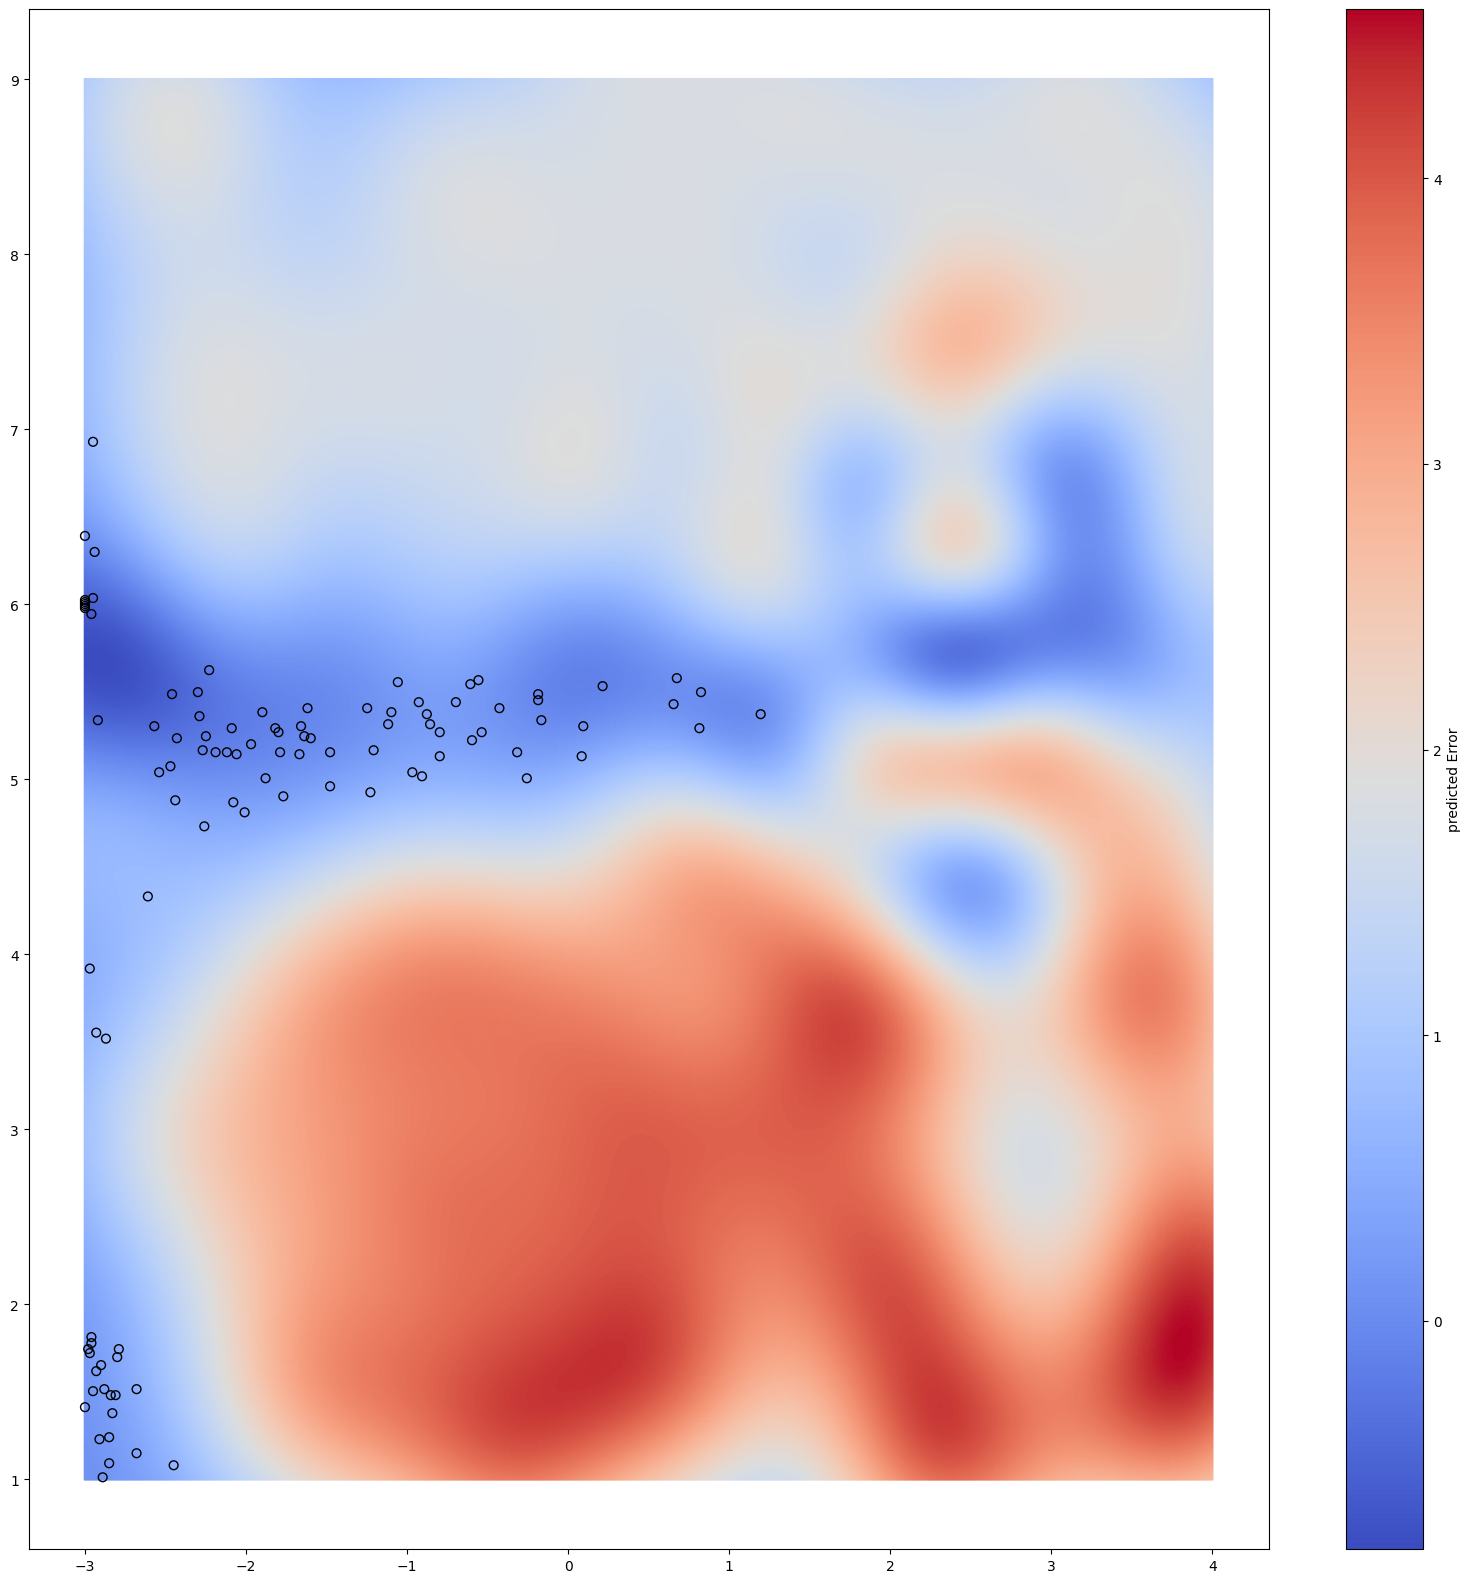

In [137]:
### determine where to acquire new observations. 
# Then randomly select half of them to be observed
X_new = acq_new(X_pred_grid, y_grid_pred, y_std, n_std=1, privilege=5, plot=True)


In [ ]:
# randomly select half of the rows in X_new, and put them in X_observ
X_observ, X_pred2 = train_test_split(X_new, test_size=0.5, random_state=0)

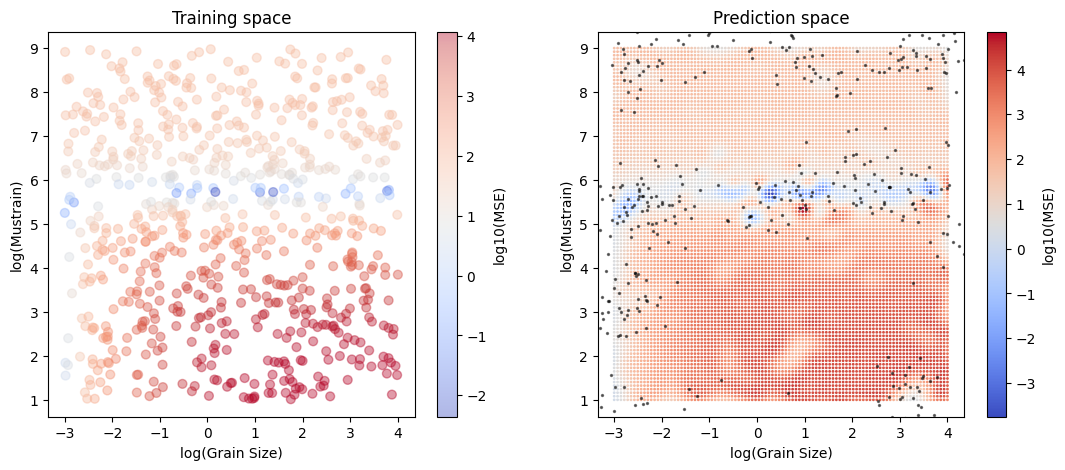

gs:  1.7886495290574351 mu:  486260.1580065353 
log(MSE):  -3.7532130242611004
y_train range:  4.077558379774526 -2.3592869665943055 
y_grid_pred range:  4.844650350616924 -3.7532130242611004


In [17]:
'''OPTIONAL: STEP 3 PLOTTING & PRINT OUTPUT'''

# For plotting a heatmap, reshape prediction to 100x100
reshape = (len(gs_grid), len(gs_grid))
pred_heatmap = y_grid_pred.reshape(reshape)
std_heatmap = y_std.reshape(reshape)

cmap = 'coolwarm'

# create two subplots on the same row
fig, axs = plt.subplots(1, 2, figsize=(13, 5))


scatter_train = axs[0].scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cmap, s = 40,
                alpha=0.4,
            #  edgecolor='k'
                )

scatter_pred = axs[1].scatter(X_grid[:,0], X_grid[:,1], c=y_grid_pred, cmap=cmap, s = 1,
                    alpha=1,
                    #  edgecolor='k'
                        )

# fix the x and y limit for ax[1]
axs[1].set_xlim(axs[0].get_xlim()) 
axs[1].set_ylim(axs[0].get_ylim())

scatter_observ = axs[1].scatter(X_observ[:,0], X_observ[:,1], c='k', cmap=cmap, s = 2,
                    alpha=0.5)

# add a color bar for the heat map
cbarL = fig.colorbar(scatter_train, ax = axs[0])
cbarR = fig.colorbar(scatter_pred, ax = axs[1])
cbarL.set_label('log10(MSE)')
cbarR.set_label('log10(MSE)')

# add labels and title
axs[0].set_xlabel('log(Grain Size)')
axs[0].set_ylabel('log(Mustrain)')
axs[0].set_title('Training space')

axs[1].set_xlabel('log(Grain Size)')
axs[1].set_ylabel('log(Mustrain)')
axs[1].set_title('Prediction space')

# show the plot
plt.show()

# find the value of the max and min of the heatmap (make sure range is silimar so color scheme is comparable)
print('gs: ', opt_gs, 'mu: ', opt_mu, 
      '\nlog(MSE): ', y_grid_pred[np.argmin(y_grid_pred)])
print('y_train range: ', np.max(y_train), np.min(y_train),
      '\ny_grid_pred range: ', np.max(y_grid_pred), np.min(y_grid_pred))

1. Suggests: balance observation time to prediction time (now too many samlling points; use more prediction)
2. Results: no need to be too precise
3. Way to do Gaussian: concatenate new points onto old ones and fit again

Total points to observe 39200 (points to exploit 19600 , points to explore 19600 )


ValueError: 'c' argument has 400 elements, which is inconsistent with 'x' and 'y' with size 19600.

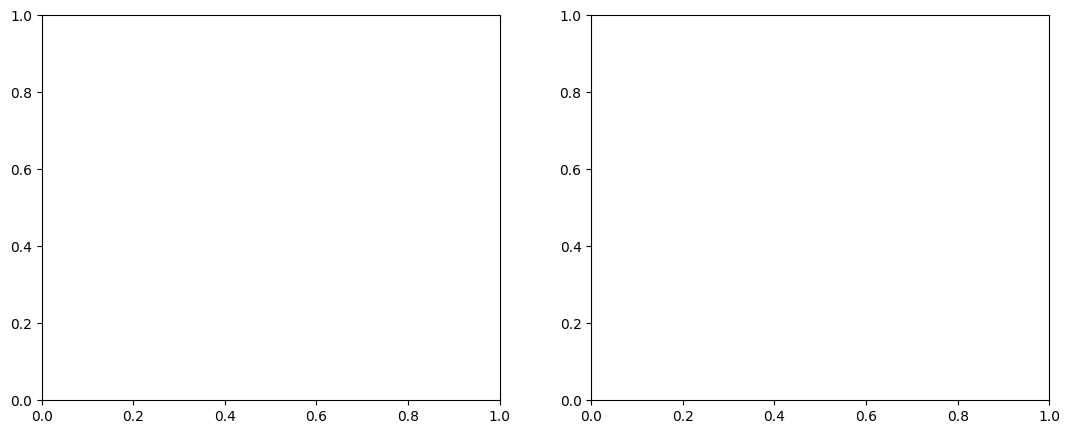

In [25]:
X_new = acq_new(X_grid, y_grid_pred, y_std, f_center = 0.08, f_perform = 0.5, 
              std_scatter = 0.4, observ_per_center=1)

# randomly select half of the rows in X_new, and put them in X_observ
X_observ, X_pred2 = train_test_split(X_new, test_size=0.5, random_state=0)

'''OPTIONAL: ANOTHER PLOTTING STEP'''
# create two subplots on the same row
fig, axs = plt.subplots(1, 2, figsize=(13, 5))


scatter_train = axs[0].scatter(X_observ[:,0], X_observ[:,1], c=y_observ, cmap=cmap, s = 40,
                alpha=1,
            #  edgecolor='k'
                )

scatter_pred = axs[1].scatter(X_grid[:,0], X_grid[:,1], c=y_grid_pred, cmap=cmap, s = 1,
                    alpha=1,
                    #  edgecolor='k'
                        )

# fix the x and y limit for ax[1]
axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

scatter_observ = axs[1].scatter(X_observ[:,0], X_observ[:,1], c='k', cmap=cmap, s = 2,
                    alpha=0.5)

# add a color bar for the heat map
cbarL = fig.colorbar(scatter_pred, ax = axs[0])
cbarR = fig.colorbar(scatter_pred, ax = axs[1])
cbarL.set_label('log10(MSE)')
cbarR.set_label('log10(MSE)')

# add labels and title
axs[0].set_xlabel('log(Grain Size)')
axs[0].set_ylabel('log(Mustrain)')
axs[0].set_title('Training space')

axs[1].set_xlabel('log(Grain Size)')
axs[1].set_ylabel('log(Mustrain)')
axs[1].set_title('Prediction space')

### <span style='color:Blue'> Approach 2. use grid search, and reduce domain gradually (this rely on array with **MAX**)
Below is a code that attempts to locate the "gold mine" by an exhaustive search

Two methods. 
* My method: locate the top N best performers, define a box in this range (easy to miss out, not panning)
* Jae's method: takes the center and defined a box radial-out (better but still easy to miss)
* tune to find balance betwee Large Range & High Resolution

_NEXT STEP: benchmark this against randomly selected range in terms of how fast it converge to OPT_

In [66]:
'''Method 2: Newton's method (clocktime improvements to be made)

Goal: use the parameter variance (between survivors) to determine the amount of "zoom" to apply.
(Done) can modify method 1 into using the range of top 25% of the tested points to determine new box size

further implementation:
- !!!make a range selection assit that can help to navigate the parameter space
- if the max guess is not moving within 2%, make higher definition grid
- select a proper survivor num and loser num based on result'''
# !pip install sigfig
from sigfig import round

def interpretXRD(target_pattern, model, method = 'jae', n_pixel = 20, break_criteria = 0.02, verbose = False, 
                 mu_min = 10, mu_max = 1e9, gs_min = 1e-3, gs_max = 1e4, fraction_survivors = 0.05):
    '''returns the mustrain and grainsize of the target pattern'''

    # initialize opt_mu and opt_gs supposing they are the center of the range
    opt_mu = np.sqrt(mu_min * mu_max) 
    opt_gs = np.sqrt(gs_min * gs_max)

    '''initialize the range of mustrain and grainsize to look at'''
    mu_next_range = np.logspace(np.log10(mu_min), np.log10(mu_max), n_pixel) ### a Hyperparameter, 11 is the resolution
    gs_next_range = np.logspace(np.log10(gs_min), np.log10(gs_max), n_pixel) # which is 1nm - 1cm
    # initialize while loop condition

    # Newton's init
    gs_shift = 1
    mu_shift = 1
    opt_mu_lst = [opt_mu]
    opt_gs_lst = [opt_gs]
    
    n_loop = 1 # this records the number of loops performed
    # while a condition, such as when new prediction is within 2% of the old prediction: 
    while gs_shift > break_criteria or mu_shift > break_criteria:
        ### CALCULATE FITNESS MATRIX
        #create an empty array with the same shape as the two ranges
        fitness_array = np.zeros((len(mu_next_range), len(gs_next_range)))

        # calculate fitness matrix
        i = 0
        for mu in mu_next_range:
            j = 0
            for gs in gs_next_range:
                # if the mu AND the grainsize are both in deep blue, assign fitness val to zero or NaN

                # compute the xrd using the model
                test_xrd = target_model.forward(mustrain=mu, grainsize = gs)
                # compute the fitness
                fitness_array[i, j] = fitness(targ_xrd, test_xrd)
                j += 1
            i += 1
            
        '''PLOTTING STARTS'''
        if verbose == True: # plot heat maps
           
            plt.subplots(1, 2, figsize=(10, 3))
            plt.subplot(1, 2, 1)
            plt.imshow(fitness_array, cmap="seismic")
            plt.xlabel("grainsize")
            plt.ylabel("mustrain")
            plt.title("log(MSE)")

            # make ticks using the values of mu_next_range and gs_next_range, use science notation
            plt.xticks(np.arange(0, len(gs_next_range), 10), np.round(gs_next_range[::10], 2))
            plt.yticks(np.arange(0, len(mu_next_range), 10), np.round(mu_next_range[::10], 2))
            plt.colorbar()

            # plt.subplot(1, 2, 2) # ALTERNATIVELY: can plot the density of values in the fitness array
            # # plot the density of values in the fitness array
            # plt.hist(fitness_array.flatten(), bins=100)
            # plt.title("Fitness distribution")
            # plt.xlabel("fitness")
            # plt.ylabel("count")

            plt.subplot(1, 2, 2)
            # plot the gradient of the fitness array
            slopes = np.gradient(fitness_array)
            # Calculate the magnitude of the slope at each point
            slope_arr = np.sqrt(sum(slope ** 2 for slope in slopes))
            plt.imshow(slope_arr, cmap="seismic")
            plt.title("Gradient of log(MSE)")
            plt.colorbar()

        if method == 'jae':
            '''jae's method locate the pixel with the lowest MSE, and re-center the range to look at to that pixel
            currently the amount 'zoom' applied is somewhat empirical. This can be adjusted later'''
            
            # fit_shift = abs((np.argmax(fitness_array) - max_fitness) / max_fitness)

            # update the optimal mu and gs
            min_MSE = np.argmin(fitness_array, axis = None)
            # return the index of the max value in the fitness array, store it in a tuple 
            opt_index = np.unravel_index(min_MSE, fitness_array.shape)
         
            # opt_index = np.unravel_index(max_fitness, fitness_array.shape)
            opt_mu = mu_next_range[opt_index[0]] # those two lines are needed when break loop using fit_shift
            opt_gs = gs_next_range[opt_index[1]]

            # New feature: set a condition: if the maximum is too close to boundary, pause the zoom in that axis

            # this is the 'reach' from the center we are looking at for THIS loop
            mu_reach = (mu_next_range[-1]/mu_next_range[0])**0.5
            gs_reach = (gs_next_range[-1]/gs_next_range[0])**0.5
            
            # check if max occur near mu boundary
            if opt_index[0] < len(mu_next_range)*0.2 or opt_index[0] > len(mu_next_range)*0.8:
                mu_msg = ', will not zoom'
            else:
                mu_msg = ''
                mu_reach = mu_reach**0.2 # reduce to one-tenth
            
            #now check if near gs boundary
            if opt_index[1] < len(mu_next_range)*0.2 or opt_index[1] > len(mu_next_range)*0.8:
                gs_msg = ', will not zoom'
            else: 
                gs_msg = ''
                gs_reach = gs_reach**0.5 # reduce by half

            mu_best_bound = [opt_mu/mu_reach, opt_mu*mu_reach] # [LOWER, UPPER]
            gs_best_bound = [opt_gs/gs_reach, opt_gs*gs_reach]
        
        # this is for using the xx_shift criteria to break the loop
        # append the omtimal value in the list, then calculate the change 
        opt_mu_lst.append(opt_mu)
        mu_shift = abs((opt_mu - opt_mu_lst[-2]) / opt_mu_lst[-2])
        
        opt_gs_lst.append(opt_gs)
        gs_shift = abs((opt_gs - opt_gs_lst[-2]) / opt_gs_lst[-2])

        signum = 5
        if verbose == True:
            print("\nMin MSE @ attempt:", n_loop,
                    "\nmustrain = ", round(opt_mu, signum), 
                    'within ', round(mu_best_bound[0], signum), "~", round(mu_best_bound[1], signum), mu_msg,
                    "\ngrainsize = ", round(opt_gs, signum), 
                    "within ", round(gs_best_bound[0], signum), "~", round(gs_best_bound[1], signum), gs_msg)

        '''print best ends'''

        '''DEFINE A NEW RANGE TO LOOK AT'''
        # new range is here: 
        mu_next_range = np.logspace(np.log10(mu_best_bound[0]), np.log10(mu_best_bound[1]), n_pixel) ### a Hyperparameter, 11 is the resolution
        gs_next_range = np.logspace(np.log10(gs_best_bound[0]), np.log10(gs_best_bound[1]), n_pixel)

        n_loop += 1
    return (opt_mu, opt_gs)


Min MSE @ attempt: 1 
mustrain =  428130.0 within  67855.0 ~ 2701300.0  
grainsize =  0.0054556 within  1.7252e-06 ~ 17.252 , will not zoom

Min MSE @ attempt: 2 
mustrain =  471720.0 within  326350.0 ~ 681840.0  
grainsize =  0.0083378 within  0.00014827 ~ 0.46887 

Min MSE @ attempt: 3 
mustrain =  499970.0 within  464460.0 ~ 538200.0  
grainsize =  0.010308 within  0.0013745 ~ 0.077296 

Min MSE @ attempt: 4 
mustrain =  505820.0 within  498430.0 ~ 513330.0  
grainsize =  0.011461 within  0.0041851 ~ 0.031384 

Min MSE @ attempt: 5 
mustrain =  499200.0 within  491900.0 ~ 506610.0 , will not zoom 
grainsize =  0.0097753 within  0.0059072 ~ 0.016176 

Min MSE @ attempt: 6 
mustrain =  500360.0 within  498890.0 ~ 501840.0  
grainsize =  0.010038 within  0.0078031 ~ 0.012913 

Min MSE @ attempt: 7 
mustrain =  499660.0 within  499370.0 ~ 499960.0  
grainsize =  0.0099058 within  0.0087337 ~ 0.011235 


(499663.80947046867, 0.0099057681279363)

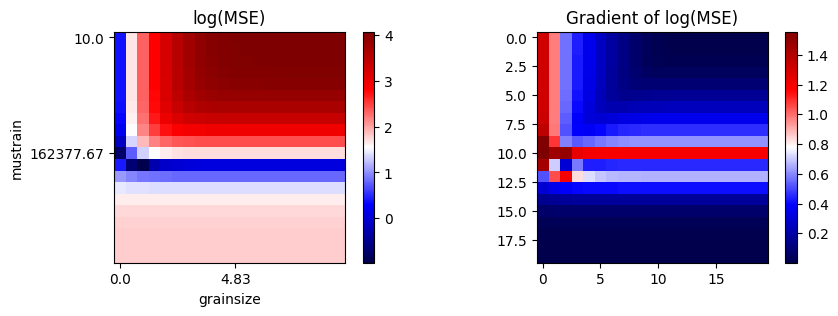

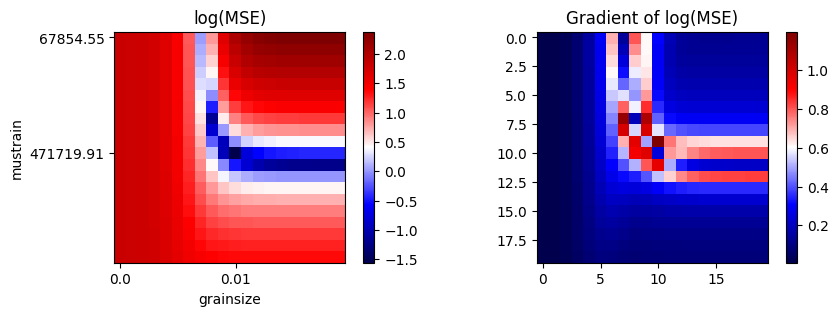

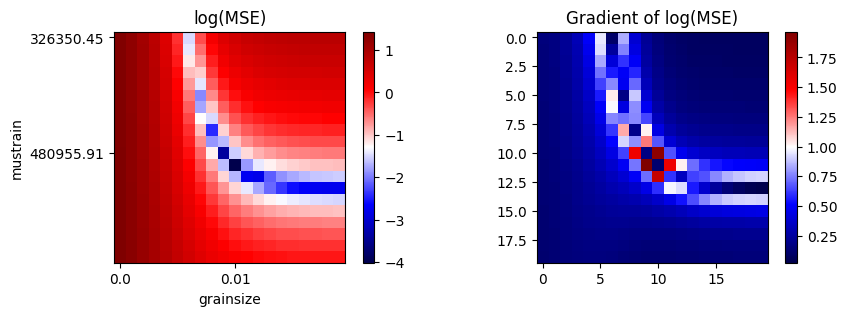

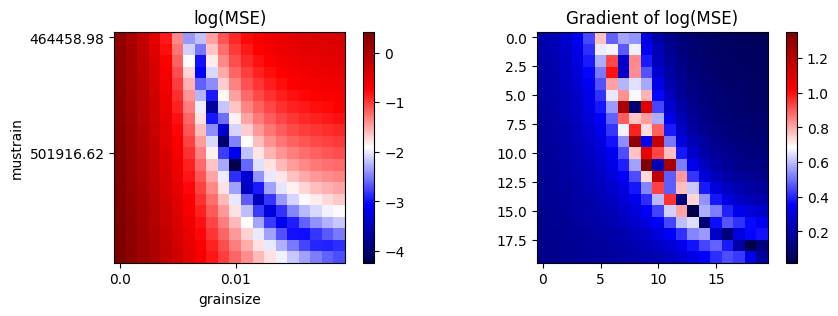

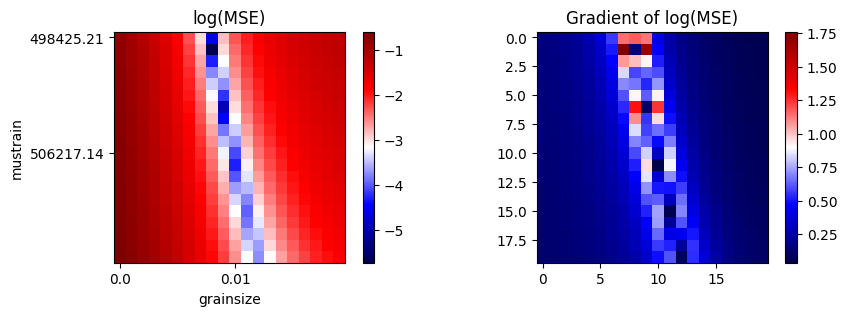

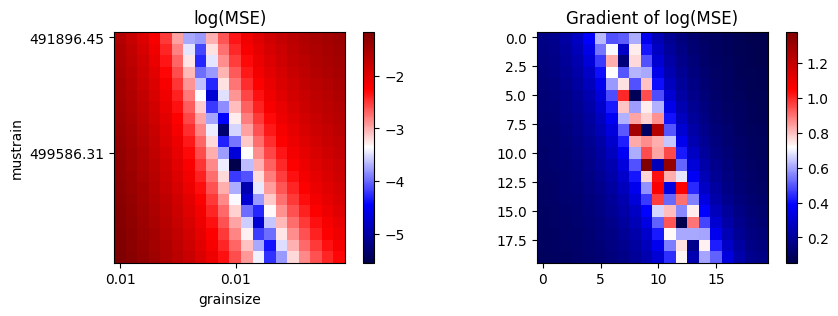

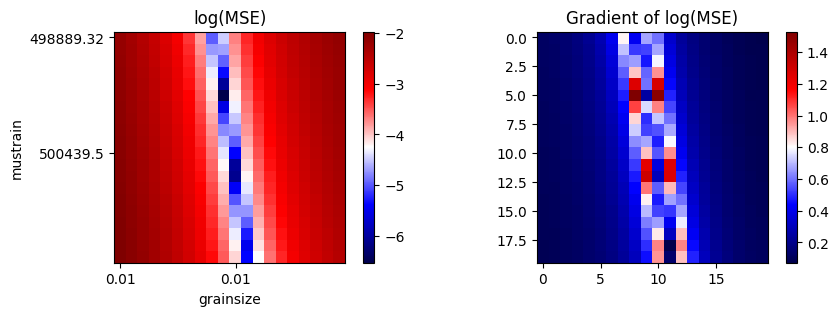

In [69]:
interpretXRD(targ_xrd, target_model, verbose = True)